<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

# План проекта

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

# Цель проекта

Обучить модель классифицировать комментарии на позитивные и негативные. Значение метрики качества F1 должно быть не меньше 0.75.

# Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
# Импортируем необходимые для работы библиотеки и модули
import pandas as pd
import re
import numpy as np

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

from lightgbm import LGBMClassifier

from tqdm.notebook import tqdm
tqdm.pandas()

import requests

import warnings
warnings.filterwarnings('ignore')

In [1]:
!pip install -q pandas jupyter pandarallel requests tqdm

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# Сохраним датасет в переменную
df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [4]:
# Изучим содержимое датасета
display(df.sample(5))
display(df.head())
print('Количество (строк, столбцов):', df.shape)
print('Количество явных дубликатов', df.duplicated().sum())
print('Количество пропусков:', df.isna().sum(), sep='\n')

,text,toxic
50155,Thanks for your concern \n\nThanks for your co...,0
89493,Thank-you Talk Contribs,0
40878,"PS - after rereading this, it sounds very atta...",0
114236,Judging from your talk page and your recent ed...,0
105140,Cue the scary music. And the laugh track. Wh...,1


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Количество (строк, столбцов): (159292, 2)
Количество явных дубликатов 0
Количество пропусков:
text     0
toxic    0
dtype: int64


<AxesSubplot:title={'center':'Соотношение количества токсичных и нет, отзывов'}>

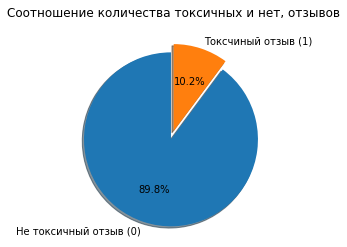

In [6]:
# Посмотрим на баланс классов 
explode = (0.1, 0)
df['toxic'].value_counts(normalize=True).plot(kind='pie', explode=explode,
                    grid=True, title='Соотношение количества токсичных и нет, отзывов', labels=['Не токсичный отзыв (0)','Токсчиный отзыв (1)'], ylabel='',
                    autopct='%1.1f%%', shadow=True, startangle=90)

In [7]:
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV
               }  
    return tag_dict.get(tag, wordnet.NOUN)

m = WordNetLemmatizer()

def lemmatize(text):
    text = [m.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
# Функция для очистки
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text).lower()
    text = " ".join(text.split())
    return text

In [11]:
# Применим очистку к датасету
df['text'] = df['text'].progress_apply(clear_text) 

  0%|          | 0/159292 [00:00<?, ?it/s]

In [12]:
# Леммантизируем
df['text'] = df['text'].progress_apply(lemmatize) 

  0%|          | 0/159292 [00:00<?, ?it/s]

In [13]:
# Выделим целевой признак
features = df.drop(['toxic'], axis=1)
target = df['toxic']

In [14]:
# Поделим на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=123, 
                                                                           stratify=target)

In [15]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

# Считаем величину TF-IDF для обучающей и тестовой выборок
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_train = count_tf_idf.fit_transform(features_train.text)
tf_test = count_tf_idf.transform(features_test.text)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Данные загружены и подготовлены к обучению:
* Данные загружены и удален ненужный для обучения столбец (который дублировал индексацию)
* Дубликаты и пропуски в датасете отсутствуют
* Произведена очистка и леммантизация текстовых значений
* Данные поделены на выборки
* Посчитаны величины TF-IDF и произведена очистка от стопслов
* Выявлен дисбаланс выборки 

## Обучение

In [16]:
# Обучим модель
model_log = LogisticRegression(random_state=12345, class_weight='balanced').fit(tf_train, target_train)
predictions = model_log.predict(tf_train)

#Рассчитаем и получим значение метрики
f1_metric = f1_score(target_train, predictions)
print('Значение метрики F1:',f1_metric)

Значение метрики F1: 0.8263977353149328


In [17]:
# Перебор производился по большему количеству параметров, выбрано лучшее, остальные удалены, чтобы уменьшить время загрузки.
grid_space = { 'max_depth':[15] }

# Найдем оптимальные значения гиперпараметров и обучим модель
model = DecisionTreeClassifier(random_state=12345, class_weight = 'balanced')
dt_class = GridSearchCV(model, param_grid=grid_space, scoring='f1', cv=3)
dt_class_v = dt_class.fit(tf_train, target_train)

# Выведим лучшее значение метрики и при каких гиперпараметрах оно было получено
print('Оптимальное значение гиперпараметров:', dt_class_v.best_params_)
print('Лучший показатель F1: {:.2f}'.format(dt_class_v.best_score_))

Оптимальное значение гиперпараметров: {'max_depth': 15}
Лучший показатель F1: 0.60


In [18]:
# Перебор производился по большему количеству параметров, выбрано лучшее, остальные удалены, чтобы уменьшить время загрузки.
grid_space = {
    'max_depth': [15],
    #'learning_rate': [0.1],
    #'cat_smooth': [1]
}

# Найдем оптимальные значения гиперпараметров и обучим модель
model = LGBMClassifier(random_state = 12345, class_weight = 'balanced')
lgbm_class = GridSearchCV(model, param_grid = grid_space, scoring='f1', cv=3)
lgbm_class_v = lgbm_class.fit(tf_train, target_train)

# Выведим лучшее значение метрики и при каких гиперпараметрах оно было получено
print('Оптимальное значение гиперпараметров:', lgbm_class_v.best_params_)
print('Лучший показатель F1: {:.2f}'.format(lgbm_class_v.best_score_))

Оптимальное значение гиперпараметров: {'max_depth': 15}
Лучший показатель F1: 0.74


Изучены показания метрики F1 при обучении на трех моделях Логистическая регрессия, Дерево решений и LGBM Классификатор.
Так как данные имеют дисбаланс, при обучении был использован параметр class_weight = 'balanced'.

Из всех трех моделей, только Логистическая регрессия показала значение метрики удовлетворяющее условию задачи (0.82), остальные модели показали значения ниже требуемого (0.75).

## Выводы

In [20]:
# Выполним проверку выбранной модели на тестовой выборке
prediction = model_log.predict(tf_test)
metric_test = f1_score(target_test, prediction)
metric_test.round(2)

0.75

В ходе выполнения проекта:

Данные были загружены и изучены, был обнаружен столбец дублирующий индексацию, он был исключен из выборки, дубликатов или пропусков в данных нет.

Проведена очистка и леммантизация текстовых значений, после чего датасет был поделен на обучающую и тестовую выборку в соотношении 75 к 25.

Текстовые значения были очищены от стоп слов и произведен расчет TF-IDF значений для признака обучающей и тестовой выборок.

Так как в данных был обнаружен дисбаланс, то при обучении моделей использовался параметр class_weight = 'balanced'.

Для обучения было выбрано три модели Логистическая регрессия, Дерево решений и LGBM Классификатор.

Так как только Логистическая регрессия показала значение F1 метрики (0.82) не ниже допустимого по условию задачи, эта модель и была выбрана для тестирования.

При проверке на тестовой выборке модель показала значени F1 метрики (0.75) удовлетворяющее условию поставленной задачи.